# Discharge pre-processing
This Notebook reads discharge daily observations (from WSC [HYDAT](https://wateroffice.ec.gc.ca/index_e.html)) for a test river basin. From these data, it calculates discharge volumes for specified target periods.

To produce a DEM for your region of interest (e.g., see the DEM_testbasin under the user-defined paths below), follow the instructions [here](https://github.com/CH-Earth/summaWorkflow_public/blob/master/3b_parameters/MERIT_Hydro_DEM/4_specify_subdomain/specify_subdomain.sh) and [here](https://github.com/CH-Earth/summaWorkflow_public/blob/master/3b_parameters/MERIT_Hydro_DEM/5_convert_to_tif/convert_vrt_to_tif.sh). A readme.txt file is otherwise available on Copernicus at: /globalhome/lla068/HPC/dem_generation/

Decisions:
- We perform a linear interpolation of the daily discharge data before calculating volumes, to fill in small data gap of maximum 15 days. See user-specified variables below.
- Volumes are calculated for the target periods: January-September, February-September, March-September, ..., September-September. We assume that there are multiple starting dates and a single end date. See user-specified variables below. 
- The volumes calculation code assumes that the target periods don't overlap 2 different years.

# Modules, paths, variables & functions
Paths & variables are the only elements you should need to modify.

In [4]:
# Import required modules
import xarray as xr
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import geopandas as gpd
import rasterio
from rasterio.plot import show

In [1]:
# Set required data paths
streamflow_obs_path = "/Users/lla068/Documents/data_driven_forecasting/data/basins_HYDAT/"  # streamflow observations directory
shp_path = "/Users/lla068/Documents/data_driven_forecasting/basins/"  # basin shapefiles directory
rivers_shp = gpd.read_file("/Users/lla068/Downloads/Lakes_and_Rivers_Shapefile/NA_Lakes_and_Rivers/data/hydrography_l_rivers_v2.shp") # North America rivers shapefile
DEM_testbasin = '/Users/lla068/Documents/data_driven_forecasting/basins/bow_MERIT_DEM.tif' # test basin DEM tif file

In [77]:
# Set user-specified variables
testbasin_id = '05BB001'  # test basin ID taken from WSC HYDAT
testbasin_name = 'Bow River at Banff'  # test basin name taken from WSC HYDAT
max_gap_days = 15  # max. number of days for gaps in the daily discharge data we perform linear interpolation for
target_period_start_month, target_period_start_day = np.arange(1,9+1), 1  # starting months and day of target period for volume calculations
target_period_end_month, target_period_end_day = 9, 30  # end month and day of target period for volume calculations

# Read test basin data

In [54]:
# Read basin's shapefile
basins_shp = gpd.read_file(shp_path+testbasin_id[0:2]+".shp")
shp_testbasin = basins_shp.loc[basins_shp.Station == testbasin_id]

display(shp_testbasin)

,Station,StationNam,Stn_UID,Shp_Area,Shp_Perime,geometry
51,05BB001,BOW RIVER AT BANFF,05BB001_1,2209.593735,340.817572,"POLYGON Z ((-116.45854 51.72693 0.00000, -116...."


In [55]:
# Read basin's daily streamflow data
streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+testbasin_id[:2]+".nc")
streamflow_testbasin = streamflow_data_ds.where(streamflow_data_ds.Station_ID == testbasin_id, drop=True).Flow #because Station_ID is not indexed
streamflow_testbasin = streamflow_testbasin.set_index({"Station_ID":"Station_ID"})
streamflow_testbasin = streamflow_testbasin.rename({"n":'Station_ID'})
streamflow_testbasin = streamflow_testbasin.assign_coords(Station_Name=("Station_ID", shp_testbasin.StationNam.values))

display(streamflow_testbasin)

<xarray.DataArray 'Flow' (Station_ID: 1, time: 62092)>
array([[nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time          (time) datetime64[ns] 1850-01-01 1850-01-02 ... 2020-01-01
    lat           (Station_ID) float64 51.17
    lon           (Station_ID) float64 -115.6
  * Station_ID    (Station_ID) object '05BB001'
    Station_Name  (Station_ID) object 'BOW RIVER AT BANFF'
Attributes:
    long_name:  Daily flow
    units:      m**3 s**-1

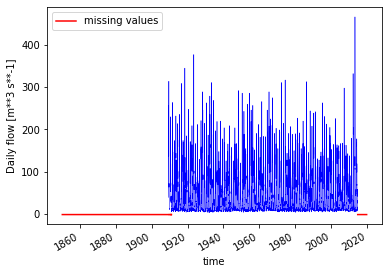

In [71]:
# Plot basin's daily streamflow data
streamflow_testbasin.plot(lw=.5, color='b')
missingvalues = streamflow_testbasin.fillna(-1)
missingvalues = missingvalues.where(missingvalues==-1)
missingvalues.plot(color='r', label='missing values')
plt.legend()
plt.title('');

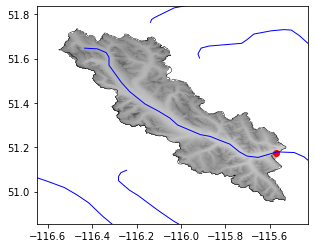

In [68]:
# Plot basin on map
fig, ax = plt.subplots()
src = rasterio.open(DEM_testbasin)
rasterio.plot.show((src, 1), cmap='Greys', vmin=0, ax=ax, alpha=.7)
rivers_shp.to_crs(epsg=4326).plot(ax=ax, color='b', lw=1)
shp_testbasin.plot(ax=ax, edgecolor='k', facecolor='none', lw=.5)
plt.scatter(streamflow_testbasin.lon, streamflow_testbasin.lat, color='red')
minx, miny, maxx, maxy = min(shp_testbasin.geometry.bounds.minx),min(shp_testbasin.geometry.bounds.miny),max(shp_testbasin.geometry.bounds.maxx),max(shp_testbasin.geometry.bounds.maxy)
ax.set_xlim(minx - .1, maxx + .1)
ax.set_ylim(miny - .1, maxy + .1);

# Calculate flow volumes

First, we plot the test basin's hydrograph climatological mean to understand what its flow regime looks like.

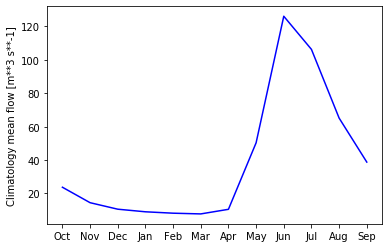

In [72]:
# Calculate climatology monthly means from daily streamflow data
water_year_months = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
monthly_climatology_mean_testbasin = streamflow_testbasin.groupby("time.month").mean(skipna=True)
plt.plot(np.arange(12), monthly_climatology_mean_testbasin.sel(month=water_year_months).data[0], color='b')
plt.title('')
plt.ylabel('Climatology mean flow ['+streamflow_testbasin.attrs['units']+']')
plt.xticks(np.arange(12), ('Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep'));

In [74]:
# Linear interpolation to fill in small data gaps (max. X days pre-defined at the top of the Notebook)
interpolated_streamflow_testbasin = streamflow_testbasin.interpolate_na(method='linear', dim='time', max_gap=datetime.timedelta(days=max_gap_days))

In [80]:
# Calculate volumes

# loop over target period starting months
for st in target_period_start_month:

    # define forecast period for which to calculate volumes - using 2010 as common year (not leap year)
    start_date = date(2010, st, target_period_start_day)
    end_date = date(2010, target_period_end_month, target_period_end_day)
    delta = end_date - start_date
    target_period_days = delta.days + 1
    start_month_datetime_object = datetime.datetime.strptime(str(st), "%m")
    start_month_name = start_month_datetime_object.strftime("%b")
    end_month_datetime_object = datetime.datetime.strptime(str(target_period_end_month), "%m")
    end_month_name = end_month_datetime_object.strftime("%b")
    
    # calculate volumes for all years' target periods with no missing data
    aggregated_streamflow_testbasin = interpolated_streamflow_testbasin.sel(time=( ((interpolated_streamflow_testbasin['time.month'] >= st) & (interpolated_streamflow_testbasin['time.month'] <= target_period_end_month)) ))
    aggregated_streamflow_testbasin = aggregated_streamflow_testbasin.groupby("time.year").sum("time", skipna=False) * 86400
    
    # save to xarray Dataset
    aggregated_streamflow_testbasin.attrs['long_name'] = 'Volumes'
    aggregated_streamflow_testbasin.attrs['info'] = 'Calculated over time period:'+start_month_name+'-'+end_month_name
    aggregated_streamflow_testbasin.attrs['units'] = 'm**3'
    aggregated_streamflow_testbasin = aggregated_streamflow_testbasin.rename('Vol_'+start_month_name+'-'+end_month_name)
    if st == target_period_start_month[0]:
        flow_volumes_testbasin = aggregated_streamflow_testbasin
    elif st != target_period_start_month[0]:
        flow_volumes_testbasin = xr.merge([aggregated_streamflow_testbasin, flow_volumes_testbasin])

display(flow_volumes_testbasin)

<xarray.Dataset>
Dimensions:       (Station_ID: 1, year: 171)
Coordinates:
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2017 2018 2019 2020
    lat           (Station_ID) float64 51.17
    lon           (Station_ID) float64 -115.6
  * Station_ID    (Station_ID) object '05BB001'
    Station_Name  (Station_ID) object 'BOW RIVER AT BANFF'
Data variables:
    Vol_Sep-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Aug-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Jul-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Jun-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_May-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Apr-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Mar-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Feb-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Jan-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan

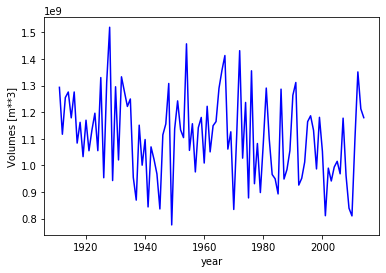

In [81]:
# Plot test basin volumes for a specific target period to see what they look like
flow_volumes_testbasin['Vol_Jan-Sep'].plot(color='b')
plt.title('');

# Store data
This can then be read in this Notebook or called in any other Notebook of this workflow without having to re-run everything each single time. To read the stored data use: %store -r dataset_name

In [82]:
%store flow_volumes_testbasin

Stored 'flow_volumes_testbasin' (Dataset)
